# Non-Negative Matrix Factorization (NMF) vs PCA

## Setup
1. Download the [CBCL faces dataset](http://www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz) and extract `face.train.tar.gz` to the same directory as this notebook.
2. Make sure that you have a working PyTorch setup (this is what we will use in this notebook).

In [1]:
import glob
import numpy as np
import torch
from PIL import Image

# Prepare data matrix X
images = []
for file in glob.glob('train/face/*.pgm'):
    images.append(torch.FloatTensor(np.array(Image.open(file))))
    
X = torch.stack(images, dim=-1)
print(f'Loaded {X.shape[2]} images of size {X.shape[0]} x {X.shape[1]}')
img_size = X.shape[:2]
X = X.flatten(0, 1) # Unroll each 2D image into a 1D vector
X /= 255 # Normalize in [0, 1]

X.shape

Loaded 2429 images of size 19 x 19


torch.Size([361, 2429])

## NMF

In [2]:
import torch.optim as optim
import torch.nn as nn
import math

K = 49 # Number of features

# Initialize W and Z from a uniform distribution U(0, 1)
# Additionally, the matrices are scaled by 1/sqrt(K) to make the variance of the resulting product independent of K
W = torch.rand(X.shape[0], K).mul_(1/math.sqrt(K)).requires_grad_()
Z = torch.rand(X.shape[1], K).mul_(1/math.sqrt(K)).requires_grad_()

optimizer = optim.Adam([W, Z], lr=0.005)
criterion = nn.MSELoss()

loss_curve = []
for i in range(5000):
    optimizer.zero_grad()
    loss = criterion(W @ Z.t(), X)
    loss.backward()
    optimizer.step()
    
    # Project onto valid set of solutions
    W.data.clamp_(min=0)
    Z.data.clamp_(min=0)
    
    loss_val = loss.item()
    loss_curve.append(loss_val)
    
    if i % 1000 == 0:
        print(f'[{i}] loss: {loss_val:.05f}')

[0] loss: 0.11291
[1000] loss: 0.00245
[2000] loss: 0.00215
[3000] loss: 0.00203
[4000] loss: 0.00200


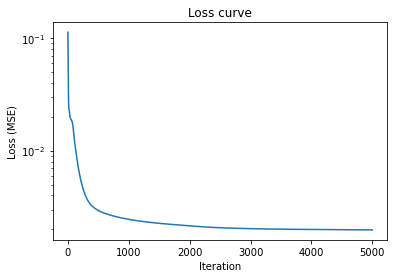

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_curve)
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

Text(0.5, 1.0, 'NMF features')

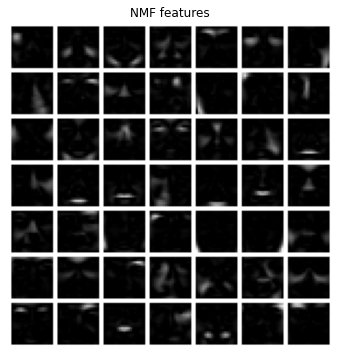

In [4]:
import torchvision

features = W.data.t().view(-1, *img_size).clone()
features = (features - features.min()) / (features.max() - features.min()) # Normalize in [0, 1]
img = torchvision.utils.make_grid(features.unsqueeze(1), nrow=int(math.sqrt(K)), pad_value=1)
plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('NMF features')

(-0.5, 6.5, 6.5, -0.5)

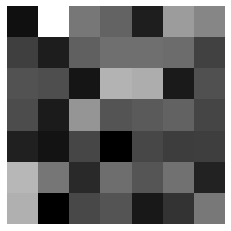

In [5]:
image_idx = 0

feature_assignment = Z.data[image_idx].clone()
feature_assignment = (feature_assignment - feature_assignment.min()) / (feature_assignment.max() - feature_assignment.min())

plt.imshow(feature_assignment.view(-1, int(math.sqrt(K))).unsqueeze(-1).expand(-1, -1, 3))
plt.axis('off')

# PCA
Essentially the same code, without projection after each update step.

In [6]:
import torch.optim as optim
import torch.nn as nn
import math

K = 49 # Number of features

# Initialize W and Z from a uniform distribution U(0, 1)
W = torch.rand(X.shape[0], K).mul_(1/math.sqrt(K)).requires_grad_()
Z = torch.rand(X.shape[1], K).mul_(1/math.sqrt(K)).requires_grad_()

optimizer = optim.Adam([W, Z], lr=0.005)
criterion = nn.MSELoss()

loss_curve = []
for i in range(3000):
    optimizer.zero_grad()
    loss = criterion(W @ Z.t(), X)
    loss.backward()
    optimizer.step()
    
    
    loss_val = loss.item()
    loss_curve.append(loss_val)
    
    if i % 1000 == 0:
        print(f'[{i}] loss: {loss_val:.05f}')

[0] loss: 0.11370
[1000] loss: 0.00170
[2000] loss: 0.00169


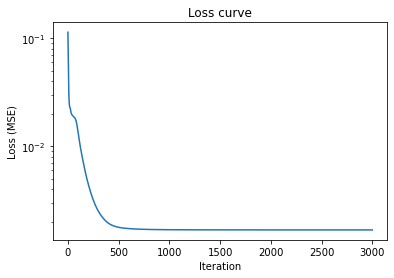

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_curve)
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

Text(0.5, 1.0, 'PCA features')

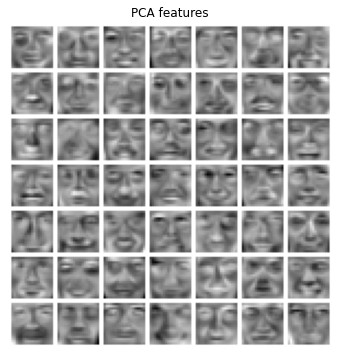

In [8]:
import torchvision

features = W.data.t().view(-1, *img_size).clone()
features = (features - features.min()) / (features.max() - features.min()) # Normalize in [0, 1]
img = torchvision.utils.make_grid(features.unsqueeze(1), nrow=int(math.sqrt(K)), pad_value=1)
plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('PCA features')

(-0.5, 6.5, 6.5, -0.5)

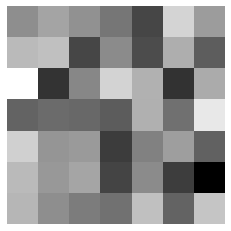

In [9]:
image_idx = 0

feature_assignment = Z.data[image_idx].clone()
feature_assignment = (feature_assignment - feature_assignment.min()) / (feature_assignment.max() - feature_assignment.min())
plt.imshow(feature_assignment.view(-1, int(math.sqrt(K))).unsqueeze(-1).expand(-1, -1, 3))
plt.axis('off')